<a href="https://colab.research.google.com/github/HuyenNguyenHelen/INFO-5505---Machine-learning/blob/main/HuyenNguyen_Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 4: Random Forest
* Dataset: [Breast Cancer Wisconsin](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data)
* Goals: Given the Breast Cancer Features computed from a digitized image of a fine needle aspirate (FNA) of a breast mass, train a model for predicting/diagnosing whether the observations are maglinant (M) or benign (B)
*   Dependent variable/ Target variable: **diagnosis**






In [1]:
# Importing essential libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Loading the dataset 

In [2]:
# Loading the dataset
data=pd.read_csv('/content/data-breastCancer.csv')
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


## Exploring the data

In [3]:
# Printing column names
print('the number of columns: {}'.format(len(data.columns)))
print('column names: \n', [name for name in data.columns])

the number of columns: 33
column names: 
 ['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32']


There are 33 variables including the independent and dependent variables. However, two of them contain no useful information such as observation identity number. Therefore, we will delete these columns.

In [5]:
# Explore the dataset with some summary statistics
data.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


The min, max, mean, and standard deviation from the above summary statistics of the dataset indicate that our data have different scales or ranges. However, fortunately, decision tree or random forest algorithms can handle well this issue because they made local optimums, unlike logistic regression or others. Therefore, we will not have to normalize our data, for maintain the model interpretability. 

### Exploring missing values

In [6]:
# Checking missing values in the dataset
data.isnull().sum()

diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

As we can see, there is no missing values, so we do not need to do data cleaning.

### Exploring the data distribution of the dependent variable

In [7]:
# Explore data distribution on the dependent variable 
print( 'class distribution in the dependent variable: \n', data['diagnosis'].value_counts())

class distribution in the dependent variable: 
 B    357
M    212
Name: diagnosis, dtype: int64


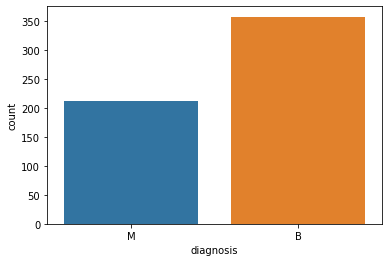

In [8]:
sns.countplot(x='diagnosis', data=data)
plt.show()

The dependent variable "diagnosis" contains binary values: M (malignant) and B (benight). However, the proportion of the two classes are imbalanced as shown from the above bar chart. We should keep this in mind later when we train and validate the model because with imbalanced of class values, our model may not have ...

### Preprocessing


* Deleting the columns contain no information: "id" and "Unnamed: 32"

In [4]:
# Deleting the columns contain no information
del data['id']
del data ['Unnamed: 32']

# Printing the numer of columns after deleting id columns
print('the number of columns: ', len(data.columns))

the number of columns:  31


* Convert discrete data into numeric. Here, only the dependent variable contain discrete values. 

In [9]:
data['diagnosis']=np.where(data['diagnosis']=='M', 1, 0)
data.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## Developing a Random Forest model
Random forest algorithm overcomes limitations of Decision tree that is sensitive to any minor changes in the input data and tend to overfit because it maximize local optimum, so it performs poorly in unseen data. Random forest also solves problems of Bagging Decision tree that uses all features for spliting creation, creating complexity of the tree.
Random forest not only  generates samples with bootstrapping method like bagging, but also take random collection of features for each subset.

Here we will create a base model with Random Forest in sklearn. Then we will experiment a variety of parameters to select the best parameters for tuning the model. 

### Spliting the data into training and testing sets
Here we will split the data into two parts: training set (80%), and test set (20%). 

For the training set (80%), we will then use k-fold cross validation method for validate our models. By doing so, the training set will be splitted into k-folds (i.e., we decide to divide into 5 folds), 4 folds for training and 1 set for validating for each iteration. 

We will not use the test set (20%) until we have finished training, and model selection. We only use the test set for evaluating our selected model to ensure having the most reliable model evaluation result before deploying the model.



In [10]:
# Spliting the data into training (80%) and testing (20%) sets
from sklearn.model_selection import train_test_split
X = data.drop('diagnosis', axis=1)
y = data['diagnosis']
X_train, X_test, y_train, y_test = train_test_split (X, y,train_size = 0.8)
print ('Shapes of X_train, y_train: ', X_train.shape, y_train.shape)
print ('Shapes of X_test, y_test: ', X_test.shape, y_test.shape)


Shapes of X_train, y_train:  (455, 30) (455,)
Shapes of X_test, y_test:  (114, 30) (114,)


### Based Model

In [11]:
# Building a Random forest model
from sklearn.ensemble import RandomForestClassifier
base_rf = RandomForestClassifier (random_state = 42)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [12]:
# Validate the model's performance using k-fold cross validation
from sklearn.model_selection import cross_validate
cv = cross_validate (base_rf, X_train, y_train, cv = 5)
print("Base model's accuracy score of 5-fold cross validation:\n", cv['test_score'])
print("Base model's cross validation accuracy score: \n", cv['test_score'].mean())

Base model's accuracy score of 5-fold cross validation:
 [0.95604396 0.96703297 0.92307692 0.97802198 0.93406593]
Base model's cross validation accuracy score: 
 0.9516483516483516


The base random forest model performed quite well, with an accuracy score of 0.967 on the training set. However, we still hope to improve the performance by tuning the hyperparameters. 

Let's see parameters used by the base model:

In [13]:
# Checking current parameters of the base model
print("Base model's parameters:\n", base_rf.get_params())

Base model's parameters:
 {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


### Tunning parameters
We can use GridSearch with Cross Validation for searching the best parameters. The algorithm ...

Below are parameters that are most important for us to tune:


*   'bootstrap':
*   'max_depth':
*   'max_features':
*   'min_sample_leaf': 
*   'min_samples_split':
*   'n_estimators':




#### Searching the best parameters for tuning

In [14]:
# Tunning parameters

# Using randomized search on hyperparameters
from sklearn.model_selection import RandomizedSearchCV

# Setting a grid of parameters to sample 
# Setting the number of trees in random forest classifiers
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10, endpoint = True)]
# Setting the number of features for each tree
max_features = ['auto', 'sqrt', 'log2']
# Setting the number of depth levels for each tree
max_depth = [int(x) for x in np.linspace(start = 3, stop = 36, num=33, endpoint = True)]
# Setting the minimum number of samples required to split an internal node
min_samples_split = [5, 10, 15]
# Setting the minimum number of samples required to be at a leaf node 
min_samples_leaf = [3, 4,5]
# Select bootstrap method for building trees 
bootstrap = ['True']

# Create the random grid
random_grid = {'n_estimators':n_estimators, 'max_features': max_features, 'max_depth': max_depth, 'min_samples_split': min_samples_split,'min_samples_leaf': min_samples_leaf, 'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36], 'min_samples_split': [5, 10, 15], 'min_samples_leaf': [3, 4, 5], 'bootstrap': ['True']}


In [15]:
# Create a base randomforest model for tuning
tune_base_rf = RandomForestClassifier(random_state=42)

# Create a randomized search cross validation model for searching for the best hyperparameters for the base rf model over 100 parameters combination
random_search_rf = RandomizedSearchCV (estimator=tune_base_rf, param_distributions  = random_grid, random_state=42, cv = 5, n_iter=100)

# fit the randomized search CV model into the training set
random_search_rf.fit(X_train, y_train)

# Print the best parameters
random_search_rf.best_params_

{'bootstrap': 'True',
 'max_depth': 28,
 'max_features': 'log2',
 'min_samples_leaf': 3,
 'min_samples_split': 5,
 'n_estimators': 300}

Using the cross validation randomized search method, we found the best parameters for our tuned random forest model. Hopefully, we could achieve a bit higher performance.

### The tuned random forest model

In [21]:
# Creating a tuned random forest model with the best parameters choosen by  the cv randomized search algorithm
tuned_rf = RandomForestClassifier (n_estimators = 300, min_samples_split = 5, min_samples_leaf = 3, max_features = 'log2',  max_depth = 28, bootstrap = True, random_state=42)

# Validating the model using k-fold cross validation (k=5)
tuned_cv = cross_validate (tuned_rf, X_train, y_train, cv = 5)
print("The tuned model's accuracy scores in 5-fold cross validation:\n", tuned_cv['test_score'])
print("The final base tuned model's cv accuracy score: \n", tuned_cv['test_score'].mean())

The tuned model's accuracy scores in 5-fold cross validation:
 [0.96703297 0.97802198 0.92307692 0.97802198 0.93406593]
The final base tuned model's cv accuracy score: 
 0.956043956043956


Unfortunately, the tuned model performed a bit worse than the base model did. Therefore, we will select the base model as our final model.  

### Evaluate the selected model

In [23]:
# Fit the selected model to the training set
tuned_rf.fit(X_train, y_train)

# Applying the selected model to make prediction on the test set
pred = tuned_rf.predict(X_test)

# Observing the estimate probability of classess in the test set
pred_prob = tuned_rf.predict_proba (X_test)
print ('class_0', 'class_1')
print(pred_prob[:10])


class_0 class_1
[[9.55021164e-01 4.49788360e-02]
 [9.87833333e-01 1.21666667e-02]
 [2.73015873e-03 9.97269841e-01]
 [9.94269841e-01 5.73015873e-03]
 [9.72740741e-01 2.72592593e-02]
 [6.66666667e-04 9.99333333e-01]
 [1.00000000e+00 0.00000000e+00]
 [1.11428571e-02 9.88857143e-01]
 [9.84240741e-01 1.57592593e-02]
 [9.98222222e-01 1.77777778e-03]]


The result of the estimate probabilities show how classes were assigned. It is a nx2 array. The first column (dimension) is for class 0, and another for the class 1. In the first instance, it was assigned class 0 because it got a probability of 0.6 for this class.

In [24]:
# Evaluate the selected model on the test set with acurracy scores
print('Accuracy of the selected model in the test set: {:.4f}'.format(tuned_rf.score(X_test, y_test)))

Accuracy of the selected model in the test set: 0.9561


Text(33.0, 0.5, 'actual values')

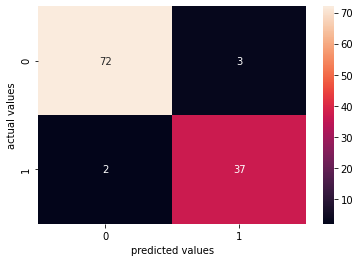

In [25]:
# Evaluate the selected model on the test set  with confusion matrix
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, pred )
# visualizing confusion matrix
sns.heatmap(conf_matrix, annot = True)
plt.xlabel ('predicted values')
plt.ylabel ('actual values')


#### Evaluating the selected model with the ROC curve
We were aware of the imbalanced proportions of the two classes in previous section. Therefore, accuracy score may not make sense. Note that the Malignant (class 1) acounts a lower portion in the dataset, so even if its accuracy is high, the cost for the low False Negative is quite high. Receiver Operating Characteristic (ROC) Curve is a good method that enables us to balance True Positive Rate (TPR) and False Positive Rate (FPR). 

*   TPR = TP/P = TP/(TP+FN)
*   FPR = FP/N = FP/ (FP+TN)



In [29]:
from sklearn.metrics import roc_curve, roc_auc_score
# Taking the probability of the class 1 (Malignant) on the test set
pred_prob_c1 = pred_prob[:,1]

# Getting True Positive Rate (tpr) and False Positive Rate (fpr)
tpr, fpr, threshold = roc_curve (y_test,pred_prob_c1)

# Computing Area Under the ROC Curve (roc_auc)
roc_auc_score = roc_auc_score (y_test,pred_prob_c1)
roc_auc_score

0.9921367521367522

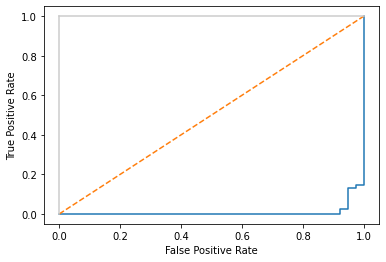

In [38]:
# Visualizing the ROC Curve
plt.plot(fpr, tpr)
plt.plot([0,1], '--')
plt.plot([0, 0], [1, 0] , c=".8")
plt.plot([1, 1] , c=".8")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()